In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [14]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [16]:
# investigate table structure of 'measurement' table
first_row = session.query(Measurements).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1970120fa70>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1}

In [17]:
# investigate table structure of 'station' table
first_row = session.query(Stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1970120cef0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
session.query(Measurements.date).order_by(Measurements.date.desc()).first()

('2017-08-23',)

In [19]:
# extract most recent date and one year prior from sqlite (which is a string) to ISO date format --
most_recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
most_recent_date_str = most_recent_date[0]
# convert datet into datetime.date format
most_recent_date_dt = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d').date()
type(most_recent_date_dt)  # delete this later
year_prior = most_recent_date_dt.year - 1
print(year_prior)  # keep?
# determine date one year prior, in datetime.date format (this format can be used in a sqlalchemy filter)
year_prior_date_old = dt.datetime(year_prior, most_recent_date_dt.month, most_recent_date_dt.day).date()
year_prior_date_old

2016


datetime.date(2016, 8, 23)

In [58]:

def one_year_prior_as_date (date_range_end):
    most_recent_date_str = date_range_end[0]
    # convert datet into datetime.date format
    most_recent_date_dt = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d').date()
    type(most_recent_date_dt)  # delete this later
    year_prior = most_recent_date_dt.year - 1
    # determine date one year prior, in datetime.date format (this format can be used in a sqlalchemy filter)
    year_prior_date = dt.datetime(year_prior, most_recent_date_dt.month, most_recent_date_dt.day).date()
    return year_prior_date

In [60]:
print(one_year_prior_as_date(most_recent_date))
year_prior_date = one_year_prior_as_date(most_recent_date)
print(year_prior_date)

2016-08-23


In [13]:
last = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_date = (last.date)
# yr = func.strftime("%m", last.date)
# type(yr)
last_date 
# last_date.strftime("%m")
# strftime('%Y %m %d','now')
# date_object = dt.strptime(last_date, '%m-%d-%Y').date()
# print(type(date_object))
# print(date_object)  # printed in default forma

last_date_dt = dt.datetime.strptime(last_date, '%Y-%m-%d').date()

year_prior = last_date_dt.year - 1
year_prior_date_old = dt.datetime(year_prior, last_date_dt.month, last_date_dt.day).date()
print(year_prior_date)
last_date_dt_full = dt.datetime.strptime(last_date, '%Y-%m-%d')
last_date_dt_full


2016-08-23


datetime.datetime(2017, 8, 23, 0, 0)

In [86]:
year_prior_date + dt.timedelta(days = 7)
type(last_date)
yrprior = year_prior_date.strftime('%Y-%m-%d')
type(yrprior)

str

In [64]:
# investigate number of rows in sqlite table: --
allrows = session.query(Measurements).count()
# need to determine if there are any Null (blanks) in prcp column in order to plot the data later --
allrows_filtered = session.query(Measurements).filter(Measurements.prcp != "").count()
print(f"There are a total of {allrows} rows in the measurements table; and \n  \
      {allrows_filtered} rows without blanks in the prcp column")


There are a total of 19550 rows in the measurements table; and 
        18103 rows without blanks in the prcp column


In [59]:
last_12_mo = session.query(Measurements).filter(Measurements.date >= year_prior_date) 
#                           to match solution provided below, add '='
last_12_mo.first().__dict__
last_12_mo.count()

2230

In [61]:
last_12_mo_data = session.query(Measurements).filter(Measurements.date >= year_prior_date)
# note: based on the provided solution, include 2016-08-23 in the analysis (thus '>=', not '>')
last_12_mo_data_clean = last_12_mo_data.filter(Measurements.prcp != "")
print(f"There are a total of {last_12_mo_data.count()} rows of data in last year of measurements; and \n  \
      of this subset, {last_12_mo_data_clean.count()} rows without blanks in the prcp column")

There are a total of 2230 rows of data in last year of measurements; and 
        of this subset, 2021 rows without blanks in the prcp column


In [65]:
m_clean = allrows.filter(Measurements.prcp != "")
m_clean.count()

AttributeError: 'int' object has no attribute 'filter'

In [108]:
m_clean2 = last_12_mo.filter(Measurements.prcp != "")
m_clean2.count()

2021

In [67]:
tabl = session.query(Measurements)
for row in tabl:
    if row.id < 7:
        print(row.prcp, row.date)

0.08 2010-01-01
0.0 2010-01-02
0.0 2010-01-03
0.0 2010-01-04
None 2010-01-06
0.06 2010-01-07


In [71]:
dates_list = []
precipitation_list = []
for row in last_12_mo_data_clean: 
    dates_list.append(row.date) 
    precipitation_list.append(row.prcp)     
        
len(dates_list), len(precipitation_list)  # delete this 
result_dict = {dates_list[i]: precipitation_list[i] for i in range(len(dates_list))}
len(result_dict)

366

In [26]:
# stadtes_df = pd.DataFrame(
#     {'prec' : [session.query(Measurements.prcp)]}
# )
df = pd.DataFrame(
    {"date" : dates_list,
    "precp" : precipitation_list}
)
# df.set_index('date', inplace=True)  # do i want an index?
df

,date,precp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2016,2017-08-17,0.13
2017,2017-08-19,0.09
2018,2017-08-21,0.56
2019,2017-08-22,0.50


In [30]:
dictionary = dict(zip(dates_list, precipitation_list))
dictionary

{'2016-08-23': 0.7,
 '2016-08-24': 1.45,
 '2016-08-25': 0.11,
 '2016-08-26': 0.01,
 '2016-08-27': 0.12,
 '2016-08-28': 2.07,
 '2016-08-29': 0.9,
 '2016-08-30': 0.05,
 '2016-08-31': 2.46,
 '2016-09-01': 0.01,
 '2016-09-02': 0.03,
 '2016-09-03': 1.0,
 '2016-09-04': 0.44,
 '2016-09-07': 1.35,
 '2016-09-08': 0.15,
 '2016-09-09': 0.35,
 '2016-09-10': 1.16,
 '2016-09-11': 0.6,
 '2016-09-12': 1.04,
 '2016-09-13': 1.2,
 '2016-09-14': 6.7,
 '2016-09-15': 3.35,
 '2016-09-16': 0.61,
 '2016-09-17': 0.23,
 '2016-09-18': 0.42,
 '2016-09-19': 0.25,
 '2016-09-20': 0.43,
 '2016-09-21': 1.02,
 '2016-09-22': 0.75,
 '2016-09-23': 0.33,
 '2016-09-24': 0.27,
 '2016-09-25': 0.04,
 '2016-09-26': 1.02,
 '2016-09-27': 1.0,
 '2016-09-28': 0.05,
 '2016-09-29': 1.49,
 '2016-09-30': 0.38,
 '2016-10-01': 1.02,
 '2016-10-02': 0.61,
 '2016-10-03': 0.46,
 '2016-10-04': 3.46,
 '2016-10-05': 0.81,
 '2016-10-06': 0.04,
 '2016-10-07': 0.01,
 '2016-10-08': 0.04,
 '2016-10-09': 0.0,
 '2016-10-10': 0.0,
 '2016-10-11': 0.35,
 

In [28]:
dict_df = df.set_index('date')['precp'].to_dict()
print(dict_df)
dict_df

{'2016-08-23': 0.7, '2016-08-24': 1.45, '2016-08-25': 0.11, '2016-08-26': 0.01, '2016-08-27': 0.12, '2016-08-28': 2.07, '2016-08-29': 0.9, '2016-08-30': 0.05, '2016-08-31': 2.46, '2016-09-01': 0.01, '2016-09-02': 0.03, '2016-09-03': 1.0, '2016-09-04': 0.44, '2016-09-07': 1.35, '2016-09-08': 0.15, '2016-09-09': 0.35, '2016-09-10': 1.16, '2016-09-11': 0.6, '2016-09-12': 1.04, '2016-09-13': 1.2, '2016-09-14': 6.7, '2016-09-15': 3.35, '2016-09-16': 0.61, '2016-09-17': 0.23, '2016-09-18': 0.42, '2016-09-19': 0.25, '2016-09-20': 0.43, '2016-09-21': 1.02, '2016-09-22': 0.75, '2016-09-23': 0.33, '2016-09-24': 0.27, '2016-09-25': 0.04, '2016-09-26': 1.02, '2016-09-27': 1.0, '2016-09-28': 0.05, '2016-09-29': 1.49, '2016-09-30': 0.38, '2016-10-01': 1.02, '2016-10-02': 0.61, '2016-10-03': 0.46, '2016-10-04': 3.46, '2016-10-05': 0.81, '2016-10-06': 0.04, '2016-10-07': 0.01, '2016-10-08': 0.04, '2016-10-09': 0.0, '2016-10-10': 0.0, '2016-10-11': 0.35, '2016-10-12': 0.02, '2016-10-13': 0.06, '2016-10

{'2016-08-23': 0.7,
 '2016-08-24': 1.45,
 '2016-08-25': 0.11,
 '2016-08-26': 0.01,
 '2016-08-27': 0.12,
 '2016-08-28': 2.07,
 '2016-08-29': 0.9,
 '2016-08-30': 0.05,
 '2016-08-31': 2.46,
 '2016-09-01': 0.01,
 '2016-09-02': 0.03,
 '2016-09-03': 1.0,
 '2016-09-04': 0.44,
 '2016-09-07': 1.35,
 '2016-09-08': 0.15,
 '2016-09-09': 0.35,
 '2016-09-10': 1.16,
 '2016-09-11': 0.6,
 '2016-09-12': 1.04,
 '2016-09-13': 1.2,
 '2016-09-14': 6.7,
 '2016-09-15': 3.35,
 '2016-09-16': 0.61,
 '2016-09-17': 0.23,
 '2016-09-18': 0.42,
 '2016-09-19': 0.25,
 '2016-09-20': 0.43,
 '2016-09-21': 1.02,
 '2016-09-22': 0.75,
 '2016-09-23': 0.33,
 '2016-09-24': 0.27,
 '2016-09-25': 0.04,
 '2016-09-26': 1.02,
 '2016-09-27': 1.0,
 '2016-09-28': 0.05,
 '2016-09-29': 1.49,
 '2016-09-30': 0.38,
 '2016-10-01': 1.02,
 '2016-10-02': 0.61,
 '2016-10-03': 0.46,
 '2016-10-04': 3.46,
 '2016-10-05': 0.81,
 '2016-10-06': 0.04,
 '2016-10-07': 0.01,
 '2016-10-08': 0.04,
 '2016-10-09': 0.0,
 '2016-10-10': 0.0,
 '2016-10-11': 0.35,
 

In [114]:
sorted_df = df.sort_values('date')
# sorted_df = sorted_df.loc[sorted_df['date'] < '2016-10-07', :]
sorted_df.count()


date     2021
precp    2021
dtype: int64

<Axes: xlabel='date'>

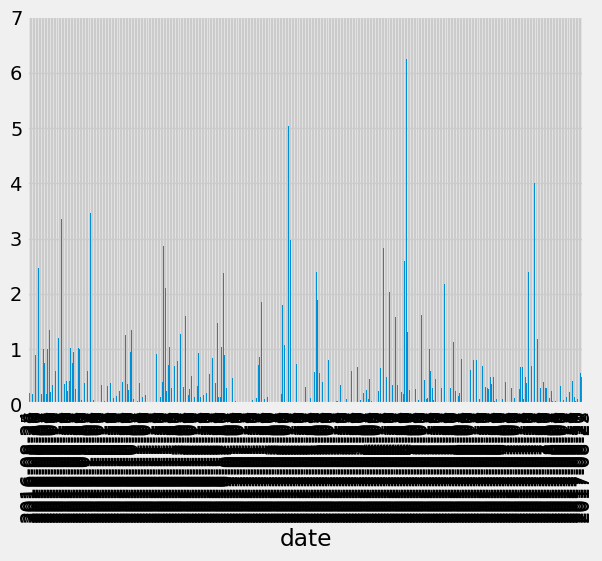

In [68]:
grouped = sorted_df.groupby(["date"])['precp'].max()
# grouped.set_index('date', inplace=True)
grouped.plot(kind = 'bar')
# grouped.head()

<Axes: xlabel='date'>

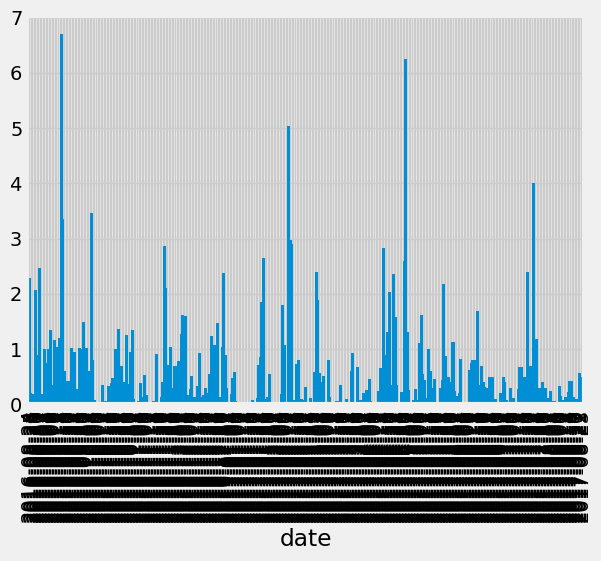

In [70]:
grouped.plot.bar(rot=90, width = 2)

In [89]:
# type(dt.datetime.
# lastd = sorted_df['date'].max()
# dt.datetime
print(last_date_dt, year_prior)

2017-08-23 2016


In [100]:
x_labels = np.arange(year_prior_date,last_date_dt, dt.timedelta(days = 60).days)
print(x_labels)
# type(last_date)
# yrprior = year_prior_date.strftime('%Y-%m-%d')
# type(yrprior)

['2016-08-23' '2016-10-22' '2016-12-21' '2017-02-19' '2017-04-20'
 '2017-06-19' '2017-08-18']


<BarContainer object of 2015 artists>

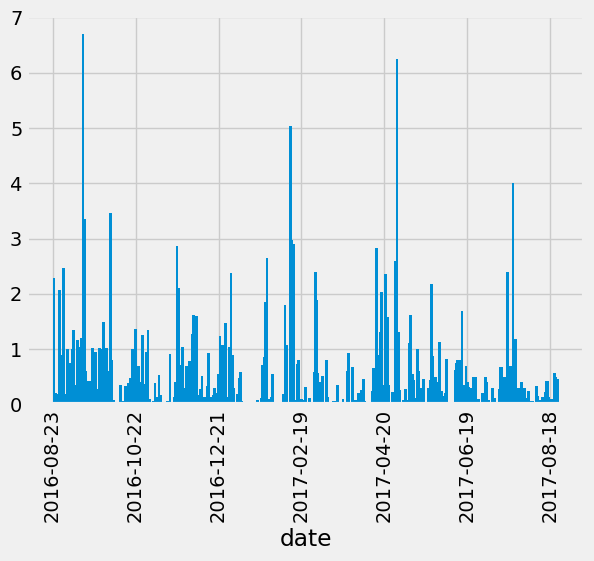

In [104]:
x_val = sorted_df['date']
y_val = sorted_df['precp']
x_labels = np.arange(year_prior_date,last_date_dt, dt.timedelta(days = 60).days)
# plt.locator_params(axis='x', nbins=4)
plt.xticks(rotation = 90)

plt.xticks(x_labels, x_labels)
plt.xlabel('date')
plt.bar(x_val, y_val, width=2)

# year_prior_date + dt.timedelta(days = 7)
# type(last_date_dt)

Text(0, 0.5, 'Inches')

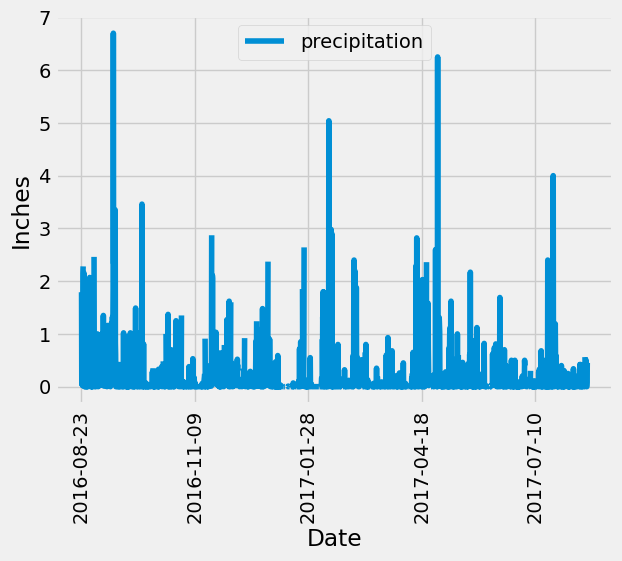

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data


In [120]:
sorted_df['date'].count()
summstat = pd.DataFrame(sorted_df['precp'].describe())
summstat


,precp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [127]:
# stations = session.query(Stations)
# stations.count()
session.query(Stations.station).distinct().count()  #looked at all fields in set
# actually go back and list columsn a prettier way

9

In [128]:
session.query(Measurements.station).distinct().count()

9

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [143]:
# session.query(Measurements).group_by(Measurements.station).func.count()
print(session.query(func.count(Measurements.station)).group_by(Measurements.station))
sel = [Measurements.station, 
       func.count(Measurements.station)]
   
station_activity = session.query(*sel).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()
station_activity
# order_by(Measurements.station)

SELECT count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [ 
       func.min(Measurements.tobs), 
       func.max(Measurements.tobs), 
       func.avg(Measurements.tobs)
       ]
most_active_station = session.query(*sel).\
    filter_by(station = 'USC00519281').\
    all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [40]:
sel = [ 
       func.min(Measurements.tobs), 
       func.max(Measurements.tobs), 
       func.avg(Measurements.tobs)
       ]
most_active_station = session.query(*sel).\
    filter_by(station = 'USC00519281').first()
# type(most_active_station)
list(most_active_station)

[54.0, 85.0, 71.66378066378067]

In [44]:
session.query(Measurements.date).order_by(Measurements.date.desc()).first()

('2017-08-23',)

In [44]:
maxtemp_a = session.query(func.max(Measurements.date)).filter_by(station = 'USC00519281').all()
maxtemp_b = session.query(Measurements.date).filter_by(station = 'USC00519281').order_by(Measurements.date.desc()).first()
maxtemp_a, maxtemp_b

([('2017-08-18',)], ('2017-08-18',))

In [45]:
type(maxtemp_a), type(maxtemp_b)

(list, sqlalchemy.engine.row.Row)

In [46]:
print(one_year_prior_as_date(maxtemp_b))
year_prior_date_USC00519281 = one_year_prior_as_date(maxtemp_b)
type(year_prior_date_USC00519281)

2016-08-18


datetime.date

In [54]:
USC00519281_only = session.query(Measurements).filter_by(station = 'USC00519281')
USC00519281_only_clean = USC00519281_only.filter(Measurements.tobs != "")
USC00519281_only_clean.count()
USC00519281_only_last_yr = USC00519281_only.filter(Measurements.date >= year_prior_date_USC00519281)
USC00519281_only_last_yr.count()

357

In [49]:
# USC00519281_only_last_yr = USC00519281_only.filter(Measurements.date >= year_prior_date_USC00519281, Measurements.date < "2017-01-01")
# USC00519281_only_last_yr.count()

136

In [55]:
TOBS_list = []
for row in USC00519281_only_last_yr: 
    TOBS_list.append(row.tobs)      
       
len(TOBS_list)

357

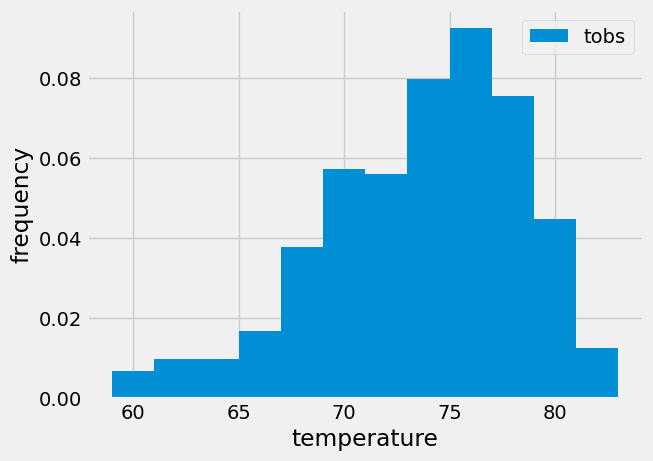

In [56]:
plt.hist(TOBS_list, 12, density=True, label="tobs")
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.legend()
plt.show()

Text(0.5, 4.183333333333314, 'Temperature')

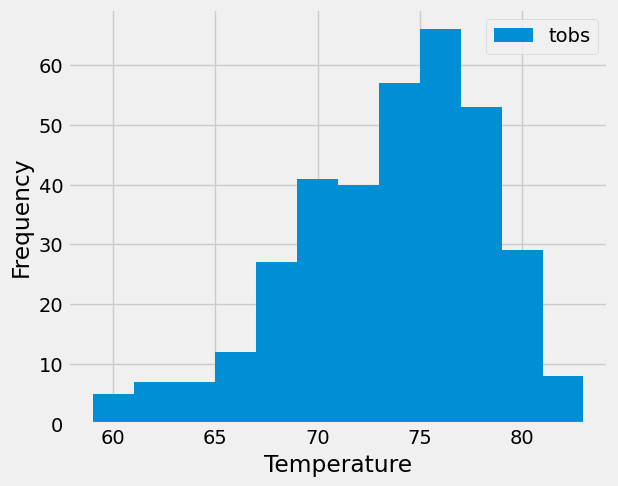

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [7]:
my_dict = {'blue': 9, 'dinosaur': 5, 'smoke': 11}

# the keys
print(my_dict.keys())

# the values
print(my_dict.values())

# how to access a value via key
print(my_dict['smoke'])

dict_keys(['blue', 'dinosaur', 'smoke'])
dict_values([9, 5, 11])
11


# Close Session

In [86]:
# Close Session
session.close()